This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [2]:
# Testing if integration works
# July 7th

In [3]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [5]:
file_name = '/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_202_6000581.h5'
hf = h5py.File(file_name)

In [6]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'norm': 0.11359075695189698, 'max': 0.000938102468702127, 'patient_id': 'c377b12cb0c316338227f305e8683fed50b6a43f6d23a6a06a87b9f7b3124b0a', 'acquisition': 'AXFLAIR'}


In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape: (number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [7]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 18, 512, 214)


In [9]:
slice_kspace = volume_kspace[12] # Choosing the 12-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [10]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

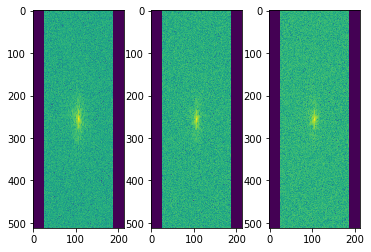

In [11]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [12]:
from data import transforms as T

In [13]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image

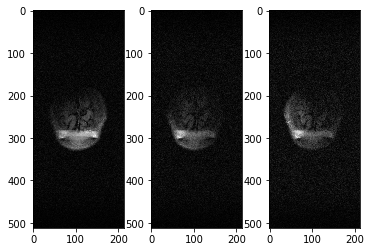

In [14]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [15]:
slice_image_rss = T.root_sum_of_squares(slice_image_abs, dim=0)

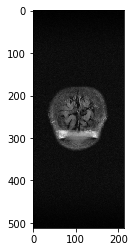

In [16]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

In [17]:
from common.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [18]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [19]:
sampled_image = T.ifft2(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = T.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = T.root_sum_of_squares(sampled_image_abs, dim=0)

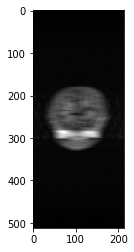

In [20]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')